### Env 실험 및 영상 저장을 위한 노트북

(gym_env_test_plot 노트북 참조)

In [1]:
import horcrux_terrain_v2
import gymnasium as gym
import numpy as np
import pandas as pd

import os
import pathlib
import time
import mediapy as media

from scipy.ndimage import uniform_filter1d
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt

from gymnasium.utils.save_video import save_video

from IPython.display import Video

### 필요 함수 정의

In [2]:
from re import I


def get_unique_filename(base_path, ext=".mp4"):
    """중복된 파일명이 존재하면 숫자를 증가하여 새로운 경로를 반환"""
    if not base_path.endswith(ext):
        base_path += ext  # 확장자 자동 추가

    file_name, file_ext = os.path.splitext(base_path)  # 파일명과 확장자 분리
    count = 0
    new_path = f"{file_name}-episode-0"+file_ext

    while os.path.exists(new_path):  # 파일 존재 여부 확인
        new_path = f"{file_name}{count}-episode-0{file_ext}"
        count += 1


    return f"rl-video{count-1}", new_path

def default_plot(x, y, f_name='default_plot', legends=['acc_x', 'acc_y', 'acc_z'], title=''):
    colors = plt.get_cmap("tab10").colors
    fig, ax = plt.subplots(figsize=(15/2.54, 10/2.54))
    ax.set_facecolor((0.95, 0.95, 0.95)) 

    n_column = len(np.shape(y))
    if n_column>2:
        print("The dimmension of data must be less than 3. (1D or 2D)")
        return -1
    
    n_data = np.shape(y)[1]

    for i in range(n_data):
        # **Plot**
        ax.plot(x, y[:,i], linewidth=1.5, linestyle="-", color=colors[i], label=legends[i])
        # ax.plot(x, y[:,i], linewidth=1.5, linestyle="-", color=colors[1], label=legends[1])
        # ax.plot(x, y[:,i], linewidth=1.5, linestyle="-", color=colors[2], label=legends[2])

    # **Grid 설정**
    ax.grid(True, linestyle="--", linewidth=1, color="#202020", alpha=0.7)  # 주요 그리드
    ax.minorticks_on()
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, color="#404040", alpha=0.5)  # 보조 그리드

    # **Axis 스타일 설정**
    ax.spines["top"].set_linewidth(1.0)
    ax.spines["right"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)

    ax.tick_params(axis="both", labelsize=11, width=1.0)  # 폰트 크기 및 라인 두께
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

    # **폰트 및 제목 설정**
    plt.rcParams["font.family"] = "Arial"
    ax.set_xlabel("X-Axis", fontsize=12, fontweight="bold")
    ax.set_ylabel("Y-Axis", fontsize=12, fontweight="bold")
    ax.set_title(title, fontsize=14, fontweight="bold")

    # **Legend (MATLAB 스타일 적용)**
    ax.legend(loc="upper right", ncol=3, fontsize=10, frameon=True)

    # **비율 설정 (MATLAB의 `pbaspect([2.1 1 1])`과 비슷한 효과)**
    fig.set_size_inches(2.1 * 5, 5)  # 비율 2.1:1 (기본 높이 5inch 기준)

    # **Save Figure (MATLAB saveas와 유사)**
    plt.savefig(f"./figs/{f_name}.png", dpi=600, bbox_inches="tight")

    plt.show()

def moving_average(data, window_size):
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='same')  # 'valid'는 경계 제외

def get_data_from_info(info):
    # Action info
    action = np.array([_info['action'] for _info in info])

    # Status info
    stat_init_rpy = np.array([_info['init_rpy'] for _info in info])
    stat_init_com = np.array([_info['init_com'] for _info in info])
    stat_xy_vel = np.array([[_info['x_velocity'], _info['y_velocity']] for _info in info])
    stat_yaw_vel = np.array([_info['yaw_velocity'] for _info in info])
    stat_quat = np.array([_info['head_quat'] for _info in info])
    stat_ang_vel = np.array([_info['head_ang_vel'] for _info in info])
    stat_lin_acc = np.array([_info['head_lin_acc'] for _info in info])
    stat_motion_vector = np.array([_info['motion_vector'] for _info in info])
    stat_com_pos = np.array([_info['com_pos'] for _info in info])
    stat_com_ypr = np.array([_info['com_ypr'] for _info in info])
    stat_step_ypr = np.array([_info['step_ypr'] for _info in info])
    stat_reward_func_orientation = np.array([_info['reward_func_orientation'] for _info in info])
    

    # Rew info
    rew_linear_movement = np.array([_info['reward_linear_movement'] for _info in info])
    reward_angular_movement = np.array([_info['reward_angular_movement'] for _info in info])
    reward_efficiency = np.array([_info['reward_efficiency'] for _info in info])
    reward_healthy = np.array([_info['reward_healthy'] for _info in info])
    cost_ctrl = np.array([_info['cost_ctrl'] for _info in info])
    cost_unhealthy = np.array([_info['cost_unhealthy'] for _info in info])
    cost_orientation = np.array([_info['cost_orientation'] for _info in info])
    cost_yaw_vel = np.array([_info['cost_yaw_vel'] for _info in info])
    direction_similarity = np.array([_info['direction_similarity'] for _info in info])
    rotation_alignment = np.array([_info['rotation_alignment'] for _info in info])
    vel_orientation = np.array([_info['velocity_theta'] for _info in info])

    # Input info
    input_joy = np.array([_info['joy_input'] for _info in info])
    gait_param = np.array([_info['gait_params'] for _info in info])

    data_dict = {
        'action': action,
        'stat_init_rpy': stat_init_rpy,
        'stat_init_com': stat_init_com,
        'stat_xy_vel': stat_xy_vel,
        'stat_yaw_vel': stat_yaw_vel,
        'stat_quat': stat_quat,
        'stat_ang_vel': stat_ang_vel,
        'stat_lin_acc': stat_lin_acc,
        'stat_motion_vector': stat_motion_vector,
        'stat_com_pos': stat_com_pos,
        'stat_com_ypr': stat_com_ypr,
        'stat_com_r_ypr':stat_reward_func_orientation,
        'stat_step_ypr': stat_step_ypr,

        'rew_linear_movement': rew_linear_movement,
        'reward_angular_movement': reward_angular_movement,
        'reward_efficiency': reward_efficiency,
        'reward_healthy': reward_healthy,
        'cost_ctrl': cost_ctrl,
        'cost_unhealthy': cost_unhealthy,
        'cost_orientation': cost_orientation,
        'cost_yaw_vel': cost_yaw_vel,
        'direction_similarity': direction_similarity,
        'rotation_alignment': rotation_alignment,
        'vel_orientation': vel_orientation,

        'input_joy': input_joy,
        'gait_param': gait_param,
    }
    
    return data_dict

ENV 생성

In [ ]:
env_config = {
    "gait_sampling_interval": 0.05,
    "forward_reward_weight": 60.0,
    "rotation_reward_weight": 40.0,
    "unhealthy_max_steps": 100.0,
    "healthy_reward": 3.0,
    "healthy_roll_range": (-35,35),
    "terminating_roll_range": (-85,85),
    "rotation_norm_cost_weight": 1.5,
    "termination_reward": 0,
    "gait_params": (75, 60, 60, 30, 0, -1),
    "use_friction_chg": False,
    "joy_input_random": False,
    "render_mode": "rgb_array",
    "render_camera_name": 'ceiling',
    "use_imu_window": True,
    "use_vels_window": True,
    "ctrl_cost_weight": 1.5,
}

env = gym.make("horcrux_terrain_v2/plane-v3", **env_config)

동작 시작 및 영상 저장

In [4]:
from scipy.io import savemat

env.reset()

env_done = False

_video_base_name = 'rl-video'

frames = []
info = []


for i in range(1000):
    _, _, _, env_done, env_info = env.step([0.75, 0.75]*7)
    pixels = env.render()
    frames.append(pixels)
    info.append(env_info)
    # print(env_info["joy_input"])

_f_name, _full_path = get_unique_filename(f"./video/{_video_base_name}")

rew_dict = get_data_from_info(info)
rew_dict['motionMatrix'] = info[-1]['motionMatrix']
save_video(frames, "./video/", name_prefix=_f_name, fps=env.metadata['render_fps'])

env.close()

# Save Reward Info mat file
savemat(f"./data/{_f_name}.mat", rew_dict)

Video(_full_path, embed=True, width=700)


In [5]:
np.array([_info['gait_params'] for _info in info])

array([[75, 50, 60, 30, 45, -1],
       [75, 50, 60, 30, 45, -1],
       [75, 50, 60, 30, 45, -1],
       ...,
       [75, 50, 60, 30, 45, -1],
       [75, 50, 60, 30, 45, -1],
       [75, 50, 60, 30, 45, -1]], shape=(1000, 6))

관련 INFO 데이터 추출

In [6]:
_len_info = len(info)

"""
"head_quat": observation[-27:-23].copy(),
"head_ang_vel": observation[-23:-20].copy(),
"head_lin_acc": observation[-20:-17].copy(),
"motion_vector": observation[-17:-3].copy(),
"""

_head_quat_array = np.array([_info['head_quat'] for _info in info])
_head_ang_vel_array = np.array([_info['head_ang_vel'] for _info in info])
_head_lin_acc_array = np.array([_info['head_lin_acc'] for _info in info])
# _motion_vector_array = np.array([_info['motion_vector'] for _info in info])

_com_rpy_array = np.array([_info['com_ypr'] for _info in info])
_com_r_rpy_array = np.array([_info['reward_func_orientation'] for _info in info])
# _com_rpy_chordal_array = np.array([_info['com_ypr_chordal'] for _info in info])

_com_xy_vel = np.array([[_info['x_velocity'], _info['y_velocity']] for _info in info])
_com_yaw_vel = np.array([_info['yaw_velocity'] for _info in info])
_com_vels = np.hstack((_com_xy_vel, _com_yaw_vel.reshape(-1,1)))

_com_rpy_array_ftd = uniform_filter1d(_com_rpy_array, axis=0, size=140)

_head_euler_array_in = Rotation.from_quat(_head_quat_array, scalar_first=True).as_euler('ZYX', degrees=True)
_ftd_head_euler_array_in = uniform_filter1d(_head_euler_array_in, axis=0, size=10)
ftd_lin_acc_array = uniform_filter1d(_head_lin_acc_array, size=10, axis=0)

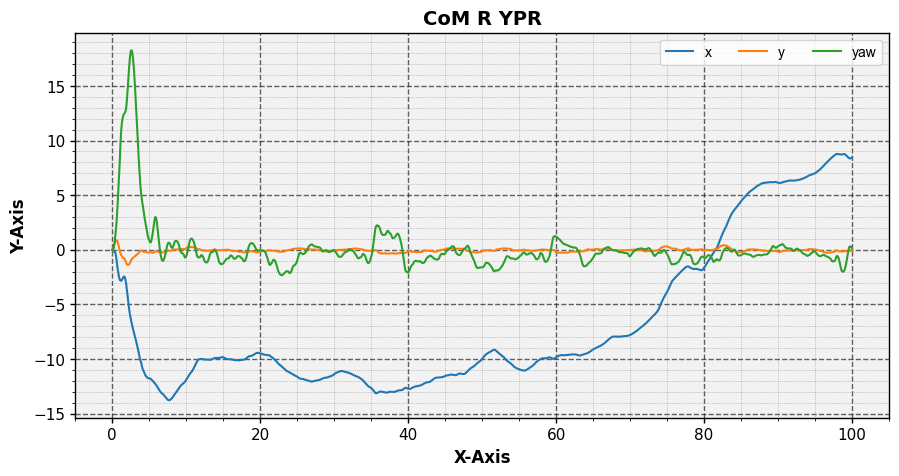

In [7]:
x = np.linspace(0, _len_info/10, _len_info)

# default_plot(x, _com_rpy_array,f_name='ttf_com_ypr', legends=['yaw', 'roll', 'pitch'])
# default_plot(x, _com_rpy_array_ftd,f_name='window_com_ypr', legends=['yaw', 'roll', 'pitch'])
# default_plot(x, _com_rpy_chordal_array,f_name='com_ypr', legends=['yaw', 'roll', 'pitch'])
# default_plot(x, _head_lin_acc_array,f_name='imu_filtered_acc', legends=['x', 'y', 'z'])
# default_plot(x, _head_euler_array_in, f_name='head_euler_movfiltered_w200_10sec', title='Intrinsic Rotation',legends=['yaw', 'pitch', 'roll'])
# default_plot(x, _head_euler_array_in, f_name='head_euler_movfiltered_w200_10sec', title='Intrinsic Rotation',legends=['yaw', 'pitch', 'roll'])
# default_plot(x, _ftd_head_euler_array_in, f_name='head_euler_int_movmean2', title='Intrinsic Rotation (Filtered)',legends=['yaw', 'pitch', 'roll'])
# default_plot(x, _com_vels, f_name='ttf_xy_vels', title='CoM XY Velocity',legends=['x', 'y', 'yaw'])
default_plot(x, _com_r_rpy_array, f_name='r_com_ypr_2P_05V_mean_quat', title='CoM R YPR',legends=['x', 'y', 'yaw'])
# default_plot(x, _com_vels, f_name='com_xy_vels', title='CoM XY Velocity',legends=['x', 'y', 'yaw'])

In [8]:
# from scipy.io import savemat
# savemat('./data/rl_data.mat', {'raw_data': _head_lin_acc_array, 'ftd_data': ftd_lin_acc_array})